In [131]:
import numpy as np
import pandas as pd
import warnings
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Back, Style
from sklearn.preprocessing import StandardScaler
import itertools
from collections import defaultdict
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, HuberRegressor
import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.model_selection import StratifiedKFold, GroupKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.stats import pearsonr, spearmanr, rankdata
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
import pickle

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Load data

In [132]:
# In kaggle
# train = pd.read_csv('../input/tabular-playground-series-aug-2022/train.csv')
# test = pd.read_csv('../input/tabular-playground-series-aug-2022/test.csv')
# submission = pd.read_csv('../input/tabular-playground-series-aug-2022/sample_submission.csv')

train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
submission = pd.read_csv('./input/sample_submission.csv')
print(f'train {train.shape}, test {test.shape}')
print(f'failure 0: {train[train.failure==0].shape[0]}, failure 1: {train[train.failure==1].shape[0]}')

train (26570, 26), test (20775, 25)
failure 0: 20921, failure 1: 5649


# Data processing

* 新增 columns (m3_missing, m5_missing)：若 measurement_3, measurement_5 為空，此欄位為1
* 使用 np.log1p 對 loading 欄位的值做轉換

In [133]:
# 合併 train & test
data = pd.concat([train, test])
data['m3_missing'] = data['measurement_3'].isnull().astype(np.int8)
data['m5_missing'] = data['measurement_5'].isnull().astype(np.int8)
data['loading'] = np.log1p(data['loading'])
display(data[:5])

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,m3_missing,m5_missing
0,0,A,4.395683,material_7,material_8,9,5,7,8,4,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0.0,0,0
1,1,A,4.453067,material_7,material_8,9,5,14,3,3,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0.0,0,0
2,2,A,4.424008,material_7,material_8,9,5,12,1,5,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0.0,0,0
3,3,A,4.625659,material_7,material_8,9,5,13,2,6,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0.0,0,0
4,4,A,5.242064,material_7,material_8,9,5,9,2,8,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0.0,0,0


* 使用 KNNImputer 補足資料 

In [134]:
feature = [f for f in test.columns if f.startswith('measurement') or f=='loading']

fill_dict = {
    'A': ['measurement_5','measurement_6','measurement_8'],
    'B': ['measurement_4','measurement_5','measurement_7'],
    'C': ['measurement_5','measurement_7','measurement_8','measurement_9'],
    'D': ['measurement_5','measurement_6','measurement_7','measurement_8'],
    'E': ['measurement_4','measurement_5','measurement_6','measurement_8'],
    'F': ['measurement_4','measurement_5','measurement_6','measurement_7'],
    'G': ['measurement_4','measurement_6','measurement_8','measurement_9'],
    'H': ['measurement_4','measurement_5','measurement_7','measurement_8','measurement_9'],
    'I': ['measurement_3','measurement_7','measurement_8']
}

for code in data.product_code.unique():
    tmp = data[data.product_code==code]
    column = fill_dict[code]
    tmp_train = tmp[column+['measurement_17']].dropna(how='any')
    tmp_test = tmp[(tmp[column].isnull().sum(axis=1)==0)&(tmp['measurement_17'].isnull())]
    print(f"code {code} has {len(tmp_test)} samples to fill nan")
    model = HuberRegressor()
    model.fit(tmp_train[column], tmp_train['measurement_17'])
    data.loc[(data.product_code==code)&(data[column].isnull().sum(axis=1)==0)&(data['measurement_17'].isnull()), 'measurement_17'] = model.predict(tmp_test[column])

    model2 = KNNImputer(n_neighbors=5)
    print(f"KNN imputing code {code}")
    data.loc[data.product_code==code, feature] = model2.fit_transform(data.loc[data.product_code==code, feature])

display(data[:5])

code A has 386 samples to fill nan
KNN imputing code A
code B has 418 samples to fill nan
KNN imputing code B
code C has 391 samples to fill nan
KNN imputing code C
code D has 398 samples to fill nan
KNN imputing code D
code E has 429 samples to fill nan
KNN imputing code E
code F has 420 samples to fill nan
KNN imputing code F
code G has 373 samples to fill nan
KNN imputing code G
code H has 361 samples to fill nan
KNN imputing code H
code I has 377 samples to fill nan
KNN imputing code I


,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,m3_missing,m5_missing
0,0,A,4.395683,material_7,material_8,9,5,7.0,8.0,4.0,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,16.180,13.034,14.684,764.100,0.0,0,0
1,1,A,4.453067,material_7,material_8,9,5,14.0,3.0,3.0,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0.0,0,0
2,2,A,4.424008,material_7,material_8,9,5,12.0,1.0,5.0,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,19.310,13.798,16.711,18.631,14.094,17.946,663.376,0.0,0,0
3,3,A,4.625659,material_7,material_8,9,5,13.0,2.0,6.0,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0.0,0,0
4,4,A,5.242064,material_7,material_8,9,5,9.0,2.0,8.0,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0.0,0,0


* 補足資料內容後，建立新的 columns

In [135]:
data['m3_17_avg'] = (data['measurement_3'] + data['measurement_17']) / 2.0
data['m3_to_16_avg'] = (data['measurement_3'] + data['measurement_4'] + data['measurement_5'] + data['measurement_6'] + data['measurement_7'] + data['measurement_8'] + data['measurement_9'] + data['measurement_10'] + data['measurement_11'] + data['measurement_12'] + data['measurement_13'] + data['measurement_14'] + data['measurement_15'] + data['measurement_16']) / 14.0
data['m3_17_stdev'] = data[['measurement_3', 'measurement_17']].std(axis=1)
data['area'] = (data['attribute_2'] * data['attribute_3'])
display(data[:5])

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,m3_missing,m5_missing,m3_17_avg,m3_to_16_avg,m3_17_stdev,area
0,0,A,4.395683,material_7,material_8,9,5,7.0,8.0,4.0,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,16.180,13.034,14.684,764.100,0.0,0,0,391.0700,15.409786,527.544085,45
1,1,A,4.453067,material_7,material_8,9,5,14.0,3.0,3.0,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0.0,0,0,350.1350,15.446286,469.408594,45
2,2,A,4.424008,material_7,material_8,9,5,12.0,1.0,5.0,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,19.310,13.798,16.711,18.631,14.094,17.946,663.376,0.0,0,0,340.7165,16.036071,456.309441,45
3,3,A,4.625659,material_7,material_8,9,5,13.0,2.0,6.0,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0.0,0,0,421.7885,15.599500,572.040194,45
4,4,A,5.242064,material_7,material_8,9,5,9.0,2.0,8.0,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0.0,0,0,299.6155,15.194071,396.360928,45


* _scale(): 對 data 的 features 進行標準化

In [136]:
def _scale(train_data, val_data, test_data, feats):
    scaler = StandardScaler()
    
    scaled_train = scaler.fit_transform(train_data[feats])
    scaled_val = scaler.transform(val_data[feats])
    scaled_test = scaler.transform(test_data[feats])
    
    # back to dataframe
    new_train = train_data.copy()
    new_val = val_data.copy()
    new_test = test_data.copy()
    
    new_train[feats] = scaled_train
    new_val[feats] = scaled_val
    new_test[feats] = scaled_test
    
    assert len(train_data) == len(new_train)
    assert len(val_data) == len(new_val)
    assert len(test_data) == len(new_test)
    
    return new_train, new_val, new_test

* 已處理完資料 分開 train 和 test data，並將 label 取出
* (因為 label (0, 1) 數量不平衡，可使用 [SMOTE](https://www.kaggle.com/code/usamabalochhh/data-is-imbalanced-use-smote?scriptVersionId=113772903) 處理訓練資料) 

In [137]:
train = data[data.failure.notnull()]
test = data[data.failure.isnull()]
print(train.shape, test.shape)

# X = train.drop(['failure'], axis=1)
X = train.drop(['id','failure','product_code','attribute_0','attribute_1'],axis=1)

y = train['failure'].astype(int)
test = test.drop(['failure'], axis=1)

# use SMOTE
# sm = SMOTE(k_neighbors=143, random_state=256)
# X_new,Y_new = sm.fit_resample(X,y)
# # X_new,Y_new = sm.fit_resample(X,y)
# X = X_new
# y = Y_new
# print(X.shape)


train.to_csv('./input/new_train.csv', index=False)
test.to_csv('./input/new_test.csv', index=False)

(26570, 32) (20775, 32)


## Train
**選擇不同組合的 feature，最後給予不同權重算出 failure**

* 選擇 feature 

In [138]:
select_feature = ['m3_missing', 'm5_missing', 'measurement_1', 'measurement_2', 'loading', 'measurement_17']

* Cross-Validation (K-fold)
* 計算各 feature 重要性 (係數絕對值越大 該特徵對預測結果的貢獻越大)

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Average auc = 0.59116, Average acc = 0.78739
OOF auc = 0.59107, OOF acc = 0.78739


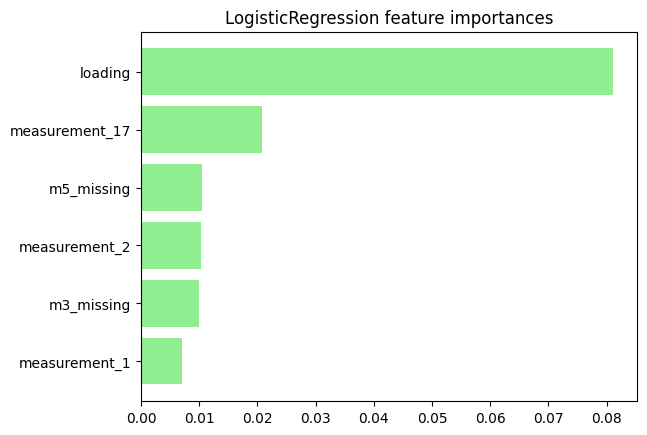

In [139]:
# variables
# lr_oof_1：LogisticRegression 在每個驗證集上預測的預測機率。
# lr_oof_2：LogisticRegression 在每個驗證集上預測的預測類別。
# lr_test：LogisticRegression 在測試資料集上預測的預測機率。
# lr_auc：LogisticRegression 在交叉驗證過程中的平均 AUC 值。
# lr_acc：LogisticRegression 在交叉驗證過程中的平均準確度。
# importance_list：LogisticRegression 在各個 fold 上的特徵重要性。

lr_oof_1 = np.zeros(len(X))
lr_oof_2 = np.zeros(len(X))
lr_test = np.zeros(len(test))
lr_auc = 0
lr_acc = 0
importance_list = []
model_list = ['./models/model1-1.pkl', './models/model1-2.pkl', './models/model1-3.pkl', './models/model1-4.pkl','./models/model1-5.pkl']

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print("Fold:", fold_idx+1)
    x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    x_test = test.copy()
    
    x_train, x_val, x_test = _scale(x_train, x_val, x_test, select_feature)
    
    model = LogisticRegression(max_iter=1000, C=0.0001, penalty='l2', solver='newton-cg') # , class_weight='balanced'
    model.fit(x_train[select_feature], y_train)

    # model.coef_ => weight(an array of weights estimated by linear regression)
    # ravel() => return contiguous flattened array (be 1D array)
    importance_list.append(model.coef_.ravel())

    val_preds = model.predict_proba(x_val[select_feature])[:, 1]
    lr_auc += roc_auc_score(y_val, val_preds) / 5
    y_preds = model.predict(x_val[select_feature])
    lr_acc += accuracy_score(y_val, y_preds) / 5
    lr_test += model.predict_proba(x_test[select_feature])[:, 1] / 5
    lr_oof_1[val_idx] = val_preds
    lr_oof_2[val_idx] = y_preds

    with open(model_list[fold_idx], 'wb') as pkl_file:
        pickle.dump(model, pkl_file, protocol=pickle.HIGHEST_PROTOCOL)

print(f"{Fore.GREEN}{Style.BRIGHT}Average auc = {round(lr_auc, 5)}, Average acc = {round(lr_acc, 5)}{Style.RESET_ALL}")
print(f"{Fore.RED}{Style.BRIGHT}OOF auc = {round(roc_auc_score(y, lr_oof_1), 5)}, OOF acc = {round(accuracy_score(y, lr_oof_2), 5)}{Style.RESET_ALL}")

importance_df = pd.DataFrame(np.array(importance_list).T, index=x_train[select_feature].columns)
importance_df['mean'] = importance_df.mean(axis=1).abs()
importance_df['feature'] = x_train[select_feature].columns
importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(20)
plt.barh(importance_df.index, importance_df['mean'], color='lightgreen')
plt.gca().invert_yaxis()
plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
plt.title('LogisticRegression feature importances')
plt.show()

In [140]:
submission['lr0'] = lr_test

In [141]:
select_feature = ['measurement_1', 'measurement_2', 'loading', 'measurement_17']

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Average auc = 0.59032, Average acc = 0.78739
OOF auc = 0.59021, OOF acc = 0.78739


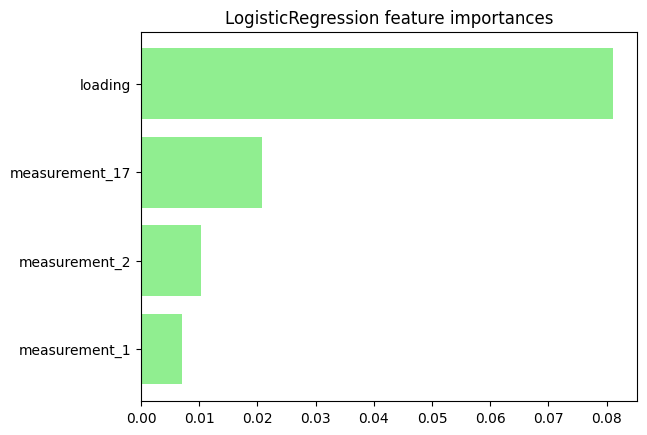

In [142]:
lr_oof_1 = np.zeros(len(X))
lr_oof_2 = np.zeros(len(X))
lr_test = np.zeros(len(test))
lr_auc = 0
lr_acc = 0
importance_list = []
model_list = ['./models/model2-1.pkl', './models/model2-2.pkl', './models/model2-3.pkl', './models/model2-4.pkl','./models/model2-5.pkl']

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print("Fold:", fold_idx+1)
    x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    x_test = test.copy()
    
    x_train, x_val, x_test = _scale(x_train, x_val, x_test, select_feature)
    #x_train, x_val, x_test = x_train.round(2), x_val.round(2), x_test.round(2)
    
    model = LogisticRegression(max_iter=1000, C=0.0001, penalty='l2', solver='newton-cg') # , class_weight='balanced'
    model.fit(x_train[select_feature], y_train)
    importance_list.append(model.coef_.ravel())

    val_preds = model.predict_proba(x_val[select_feature])[:, 1]
    lr_auc += roc_auc_score(y_val, val_preds) / 5
    y_preds = model.predict(x_val[select_feature])
    lr_acc += accuracy_score(y_val, y_preds) / 5
    lr_test += model.predict_proba(x_test[select_feature])[:, 1] / 5
    lr_oof_1[val_idx] = val_preds
    lr_oof_2[val_idx] = y_preds
    
    with open(model_list[fold_idx], 'wb') as pkl_file:
        pickle.dump(model, pkl_file, protocol=pickle.HIGHEST_PROTOCOL)

print(f"{Fore.GREEN}{Style.BRIGHT}Average auc = {round(lr_auc, 5)}, Average acc = {round(lr_acc, 5)}{Style.RESET_ALL}")
print(f"{Fore.RED}{Style.BRIGHT}OOF auc = {round(roc_auc_score(y, lr_oof_1), 5)}, OOF acc = {round(accuracy_score(y, lr_oof_2), 5)}{Style.RESET_ALL}")

importance_df = pd.DataFrame(np.array(importance_list).T, index=x_train[select_feature].columns)
importance_df['mean'] = importance_df.mean(axis=1).abs()
importance_df['feature'] = x_train[select_feature].columns
importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(20)
plt.barh(importance_df.index, importance_df['mean'], color='lightgreen')
plt.gca().invert_yaxis()
plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
plt.title('LogisticRegression feature importances')
plt.show()

In [143]:
submission['lr1'] = lr_test

In [148]:
select_feature = ['loading', 'measurement_17', 'm3_17_avg']

Fold: 1
0.5991426210061028
Fold: 2
0.5886924905666763
Fold: 3
0.5820424203455219
Fold: 4
0.5932854193810386
Fold: 5
0.5822702160781061
Average auc = 0.58909, Average acc = 0.78739
OOF auc = 0.589, OOF acc = 0.78739


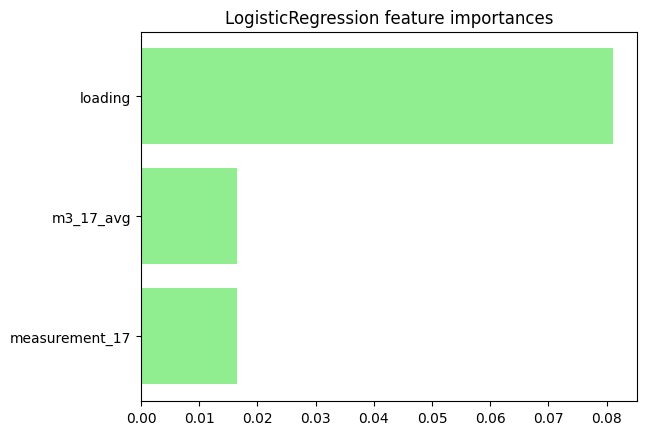

In [149]:
lr_oof_1 = np.zeros(len(X))
lr_oof_2 = np.zeros(len(X))
lr_test = np.zeros(len(test))
lr_auc = 0
lr_acc = 0
importance_list = []
model_list = ['./models/model3-1.pkl', './models/model3-2.pkl', './models/model3-3.pkl', './models/model3-4.pkl','./models/model3-5.pkl']

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print("Fold:", fold_idx+1)
    x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    x_test = test.copy()
    
    x_train, x_val, x_test = _scale(x_train, x_val, x_test, select_feature)
    #x_train, x_val, x_test = x_train.round(2), x_val.round(2), x_test.round(2)
    
    model = LogisticRegression(max_iter=1000, C=0.0001, penalty='l2', solver='newton-cg') # , class_weight='balanced'
    model.fit(x_train[select_feature], y_train)
    importance_list.append(model.coef_.ravel())

    val_preds = model.predict_proba(x_val[select_feature])[:, 1]
    lr_auc += roc_auc_score(y_val, val_preds) / 5
    y_preds = model.predict(x_val[select_feature])
    lr_acc += accuracy_score(y_val, y_preds) / 5
    lr_test += model.predict_proba(x_test[select_feature])[:, 1] / 5
    lr_oof_1[val_idx] = val_preds
    lr_oof_2[val_idx] = y_preds
    with open(model_list[fold_idx], 'wb') as pkl_file:
        pickle.dump(model, pkl_file, protocol=pickle.HIGHEST_PROTOCOL)

print(f"{Fore.GREEN}{Style.BRIGHT}Average auc = {round(lr_auc, 5)}, Average acc = {round(lr_acc, 5)}{Style.RESET_ALL}")
print(f"{Fore.RED}{Style.BRIGHT}OOF auc = {round(roc_auc_score(y, lr_oof_1), 5)}, OOF acc = {round(accuracy_score(y, lr_oof_2), 5)}{Style.RESET_ALL}")

importance_df = pd.DataFrame(np.array(importance_list).T, index=x_train[select_feature].columns)
importance_df['mean'] = importance_df.mean(axis=1).abs()
importance_df['feature'] = x_train[select_feature].columns
importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(20)
plt.barh(importance_df.index, importance_df['mean'], color='lightgreen')
plt.gca().invert_yaxis()
plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
plt.title('LogisticRegression feature importances')
plt.show()

In [146]:
submission['lr2'] = lr_test

In [147]:
submission.head()

,id,failure,lr0,lr1,lr2
0,26570,0.0,0.208906,0.208996,0.208252
1,26571,0.0,0.201129,0.201224,0.201619
2,26572,0.0,0.204884,0.204971,0.206438
3,26573,0.0,0.206612,0.206694,0.203775
4,26574,0.0,0.239220,0.239314,0.242482
